# Retrieve GPR data centered on a pit

**Goal**: Visualize a set of GPR snow depths around a pit and calculate the avg density from the pit

**Approach**: 

1. Retrieve the pit location from the Layer Data table 
2. Build a circle around the pit location 
3. Request all the GPR data with a distance of our pit
4. Request the Pit Data to get density layers and calculate the avg
4. Plot depths!


## Process
### Step 1: Get the pit/site coordinates

In [1]:
# Import our DB access function
from snowexsql.db import get_db

# Import the two tables we need GPR ---> PointData, Density (Pits) --> LayerData 
from snowexsql.data import PointData, LayerData
from snowexsql.conversions import query_to_geopandas

# Import to make use of the posgis functions on the db that are not necessarily in python 
from sqlalchemy import func, Float
# Import datetime module to filter by a date
import datetime 


# use numpy to calculate the average of the density results 
import numpy as np 

# PIT Site Identifier
site_id = '1S1'

# Distance around the pit to collect data in meters
buffer_dist = 50

# Connect to the database we made.
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Grab our pit geometry (position) object by provided site id from the site details table, Since there is multiple layers and dates we limit the request to 1
q = session.query(LayerData.geom).filter(LayerData.site_id == site_id).limit(1)
site = q.all()
print(site)


[(<WKBElement at 0x7f84d1dec6d0; 0101000020206900000000000040a4264100000040877d5041>,)]


### Step 2: Build a buffered circle around our pit

In [2]:
# Cast the geometry point into text to be used by Postgis function ST_Buffer
point = session.query(site[0].geom.ST_AsText()).all()
print(point)

# Create a polygon buffered by our distance centered on the pit using postgis ST_Buffer 
q = session.query(func.ST_Buffer(point[0][0], buffer_dist))
buffered_pit = q.all()[0][0]

[('POINT(741920 4322845)',)]


### Step 3: Request all GPR TWT measured inside the circle

In [4]:
# Collect all Point Data where the instrument string contains the GPR in its name
qry = session.query(PointData).filter(PointData.instrument.contains('GPR'))

# Additionally Filter by a date 
qry = qry.filter(PointData.date==datetime.date(2020, 1, 29))

# See upload details at https://github.com/SnowEx/snowexsql/blob/087b382b8d5098f09db67310efd49f777525c0c8/scripts/upload/add_gpr.py#L27

# Grab all the point data in the buffer using the POSTGIS ST_Within, anytime using the postgis functions we typically have to convert to text
qry = qry.filter(func.ST_Within(PointData.geom.ST_AsText(), buffered_pit.ST_AsText()))

# Use our handy dandy function to execute the query and make it a geopandas dataframe
df = query_to_geopandas(qry, engine)

### Step 4: Grab Density Profiles

In [11]:
# Request the average (avg) of Layer data casted as a float. We have to cast to a float in the layer table because all main values are stored as a string to 
# ...accomodate the hand hardness. 
qry = session.query(func.avg(LayerData.value.cast(Float)))

# Filter our query only to density 
qry = qry.filter(LayerData.type=='density')

# Request the data 
rho_avg = qry.all()
print(rho_avg)


# This is a gotcha. The data in layer data only is stored as a string to accomodate the hand hardness values 
print(f"Average of pit densities is {results[0][0]:0.0f} kg/m3")


[(266.39979706513947,)]
Average of pit densities is 266 kg/m3


### Step 4: Plot it!

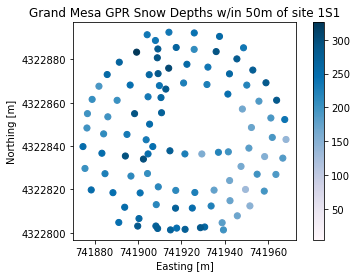

In [12]:
# Get the Matplotlib Axes object from the dataframe object, color points by snow depth value
ax = df.plot(column='value', legend=True, cmap='PuBu')

# Use non-scientific notation for x and y ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Set the various plots x/y labels and title.
ax.set_title('Grand Mesa GPR Snow Depths w/in {}m of site {}'.format(buffer_dist, site_id))
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')

# Close the session to avoid hanging transactions
session.close()